## Setup

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
FORCE_CPU = True
SEED = 2384

In [3]:
import random
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import matplotlib.pyplot as plt

import plotly.express as px

from transformer_lens.hook_points import HookedRootModule, HookPoint

from causal_networks.dag import RecurrentDeterministicDAG
from causal_networks.variable_alignment import VariableAlignment

In [4]:
if not FORCE_CPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


## Recurrent DAG

In [13]:
dag1 = RecurrentDeterministicDAG(num_streams=5)

def input_symbol_validator(symbol):
    """
    Checks if a symbol is a valid input symbol.
    it should be ( ) _ ' + - S or 0
    """
    return symbol in {'(', ')', 'S', '0'}

def interp_symbol_func(x):
    if x == '(':
        return 1
    elif x == ')':
        return -1
    else:
        return 0
    
def cumsum_func(*x):
    return sum(x)

def close_paren_func(cumsum):
    if cumsum > 0:
        return True
    else:
        return False
    
dag1.add_node("x", validator=input_symbol_validator)
dag1.add_node("v", func=interp_symbol_func)
dag1.add_node("s", func=cumsum_func)
dag1.add_node("c", func=close_paren_func, possible_values=[True, False])

dag1.add_edge("x", "v")
dag1.add_edge("v", "s", edge_type="current_and_previous_streams")
dag1.add_edge("s", "c")

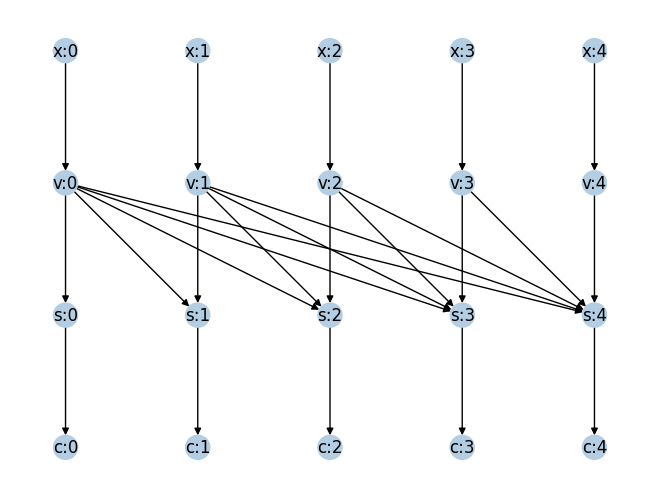

                               Node Information                                
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Node ┃ Function           ┃ Value 0 ┃ Value 1 ┃ Value 2 ┃ Value 3 ┃ Value 4 ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ x    │ -                  │ -       │ -       │ -       │ -       │ -       │
│ v    │ interp_symbol_func │ -       │ -       │ -       │ -       │ -       │
│ s    │ cumsum_func        │ -       │ -       │ -       │ -       │ -       │
│ c    │ close_paren_func   │ -       │ -       │ -       │ -       │ -       │
└──────┴────────────────────┴─────────┴─────────┴─────────┴─────────┴─────────┘

In [16]:
dag1.visualize()